In [1]:
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
channel = EngineConfigurationChannel()
env = UnityEnvironment(file_name='./Wave', seed=1, side_channels=[channel])
channel.set_configuration_parameters(time_scale = 20)
print("WAVE environment created.")

WAVE environment created.


In [3]:
l1 = 64
l2 = 150
l3 = 150
l4 = 2

model = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2,l3),
  torch.nn.ReLU(),
  torch.nn.Linear(l3,l4),
  torch.nn.Softmax(dim=1)
)
  
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
def discount_rewards(rewards: np.ndarray, gamma):
    reversed = np.copy(rewards)[::-1]
    discounted_rewards = []
    for i, reward in enumerate(reversed):
        discounted_rewards.append(reward + (0 if i == 0 else reversed[i - 1]))
        reversed[i] = reward * gamma
        if i > 0:
            reversed[i] += reversed[i - 1] * gamma
    discounted_rewards = np.array(discounted_rewards[::-1])
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    return discounted_rewards

def loss_fn(predictions, rewards):
    return -1 * torch.sum(rewards * torch.log(predictions))

def preprocess_input(inp):
    return np.append(inp.obs[1], inp.obs[0], axis=1).reshape(-1)

def get_trajectories(model):
    states = []
    actions = []
    action_sets = []
    rewards = []

    env.reset()
    behavior_name = list(env.behavior_specs)[0]
    timestep = 0
    while True:
        timestep += 1
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if (len(terminal_steps) > 0):
            break

        state = preprocess_input(decision_steps)

        states.append(state)
        pred = model(torch.Tensor(np.array([state])))
        action = np.random.choice(np.array([0, 1]), p=pred.detach().numpy().flatten())
        actions.append(action)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
        
        new_decision_steps, new_terminal_steps = env.get_steps(behavior_name)
        current_step = new_decision_steps if len(new_terminal_steps) == 0 else new_terminal_steps
        reward = current_step.reward[0]
        rewards.append(float(reward))

    return torch.from_numpy(np.array(states)).float(), np.array(actions), np.array(rewards), np.array(action_sets), timestep

In [5]:
EPOCH = 3000
GAMMA = 0.9
all_rewards = []
all_timesteps = []
all_losses = []

for i in range(EPOCH):
    states, actions, rewards, action_sets, timestep = get_trajectories(model)
    current_reward = np.sum(rewards)
    all_rewards.append(current_reward)
    all_timesteps.append(timestep)
    print(f'EPOCH: {i}, total reward: {current_reward}, timestep: {timestep}')

    predictions = model(states)
    cumulative_reward = np.sum(rewards)
    discounted_rewards = torch.tensor(discount_rewards(rewards, GAMMA))

    actions = torch.tensor(actions.reshape(-1, 1)).long()
    prob_batch = predictions.gather(dim=1,index=actions).squeeze()
    loss = loss_fn(prob_batch, discounted_rewards)
    all_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env.close()

EPOCH: 0, total reward: 15.306750878691673, timestep: 53
EPOCH: 1, total reward: 3.6889908015727997, timestep: 49
EPOCH: 2, total reward: 2.851223945617676, timestep: 29
EPOCH: 3, total reward: 27.936927743256092, timestep: 77
EPOCH: 4, total reward: 3.0007724463939667, timestep: 36
EPOCH: 5, total reward: 2.7371727377176285, timestep: 27
EPOCH: 6, total reward: 11.514315411448479, timestep: 51
EPOCH: 7, total reward: 11.637295871973038, timestep: 50
EPOCH: 8, total reward: 26.51921698451042, timestep: 78
EPOCH: 9, total reward: 3.45563705265522, timestep: 38
EPOCH: 10, total reward: 2.992528446018696, timestep: 28
EPOCH: 11, total reward: 8.582220017910004, timestep: 36
EPOCH: 12, total reward: 14.507704988121986, timestep: 52
EPOCH: 13, total reward: 11.382655054330826, timestep: 53
EPOCH: 14, total reward: 52.86075401306152, timestep: 102
EPOCH: 15, total reward: 11.777828767895699, timestep: 50
EPOCH: 16, total reward: 2.9855658560991287, timestep: 27
EPOCH: 17, total reward: 11.42

In [6]:
def avg_per_x_element(data, x=10):
    avg = []
    sum = 0
    for i, el in enumerate(data):
        sum += el
        if i % x == 0:
            avg.append(sum / x)
            sum = 0
    return avg

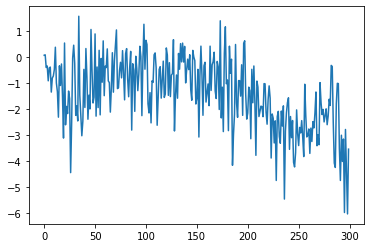

In [7]:
plt.plot(avg_per_x_element(all_losses))

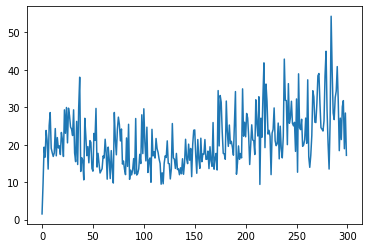

In [8]:
plt.plot(avg_per_x_element(all_rewards))

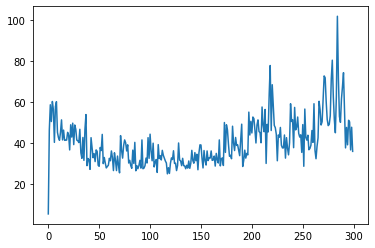

In [9]:
plt.plot(avg_per_x_element(all_timesteps))

In [23]:
def test_model(model, time_scale=3, debug=False):
    channel = EngineConfigurationChannel()
    env = UnityEnvironment(file_name='./Wave', seed=1, side_channels=[channel])
    channel.set_configuration_parameters(time_scale = time_scale)
    print("WAVE environment created.")

    env.reset()
    i = 0
    GAMMA = 0.95
    total_reward = 0
    while True:
        i += 1
        behavior_name = list(env.behavior_specs)[0]

        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if (len(terminal_steps) > 0):
            break

        preds = model(torch.Tensor([preprocess_input(decision_steps)])).detach().numpy()

        action = np.argmax(preds)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()

        new_decision_steps, new_terminal_steps = env.get_steps(behavior_name)
        current_step = new_decision_steps if len(new_terminal_steps) == 0 else new_terminal_steps
        try:
            reward = current_step.reward[0]
        except Exception as e:
            print(e)

        total_reward += reward

        qvals_2 = model(torch.Tensor(preprocess_input(current_step)))
        target = reward + GAMMA * ((1 - int(len(new_terminal_steps) > 0)) * torch.max(qvals_2, dim=1)[0])
        if debug:
            print(i, 'Decision Steps', preprocess_input(decision_steps), 'Preds', preds, 'Selected Preds', np.argmax(preds), 'Done?', int(len(new_terminal_steps) > 0), 'Next Preds', ((1 - int(len(new_terminal_steps) > 0)) * torch.max(qvals_2, dim=1)[0]), 'Target', target, 'Reward', reward, sep='\n')
            print('==================================')

    env.close()
    return total_reward, i

def test_model_avg(model, count=20, time_scale=10):
    sum_reward = 0
    sum_timesteps = 0
    for _ in range(count):
        reward, timesteps = test_model(model, time_scale)
        sum_timesteps += timesteps
        sum_reward += reward
    return sum / count

In [26]:
test_model_avg(model)

UnityWorkerInUseException: Couldn't start socket communication because worker number 0 is still in use. You may need to manually close a previously opened environment or use a different worker number.

In [25]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.